This notebook includes standard data cleaning, Exploratory data analysis(EDA), Model traing(Random forest classifier) and Evaluation.

In [1]:
import kagglehub

# Download latest version
#path = kagglehub.dataset_download("laotse/credit-risk-dataset")

print("Path to dataset files:", path)

100%|██████████| 368k/368k [00:00<00:00, 982kB/s]

Extracting files...
Path to dataset files: C:\Users\User\.cache\kagglehub\datasets\laotse\credit-risk-dataset\versions\1


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer  #Used to apply different preprocessing steps to different columns
from sklearn.preprocessing import StandardScaler, OneHotEncoder  #  "OneHotEncoder"  Converts categorical variables (like "red", "blue", "green") into numeric binary columns.
from sklearn.impute import SimpleImputer  #Fills in missing values:For numeric columns(mean, median). For categorical: most frequent, constant value
from sklearn.pipeline import Pipeline  #Ensures training and predictions apply identical transformations.
from sklearn.metrics import classification_report, confusion_matrix #classification_report gives precision, recall, f1-score.confusion_matrix shows correct vs incorrect predictions.
from sklearn.ensemble import RandomForestClassifier
pd.set_option('display.max_columns', None)

In [11]:
df = pd.read_csv(r"C:\Users\User\Downloads\archive (8)\credit_risk_dataset.csv")
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


Data Cleaning

In [13]:
df.shape
df.info()
df.isna().sum()
df.drop_duplicates()
#removing columns with too many missing values
threshold = 0.3
col_to_drop = df.columns[df.isna().mean()>threshold]
df = df.drop(columns = col_to_drop)
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


Preprocessing

In [23]:
target = "loan_status"
num_col = ['person_age','person_income','person_emp_length','loan_amnt','loan_int_rate','loan_percent_income','cb_person_cred_hist_length']
non_num_col = ['person_home_ownership','loan_intent','loan_grade','cb_person_default_on_file']
#Numerical Pipeline
num_pipe = Pipeline(steps = [('imputer', SimpleImputer(strategy = 'median')),
                            ('scaler', StandardScaler())])
#categorical Pipeline
non_num_pipe = Pipeline(steps =[('imputer', SimpleImputer(strategy = 'most_frequent')),
                               ('encoder', OneHotEncoder(handle_unknown = 'ignore'))])
preprocessor = ColumnTransformer(
    transformers = [
        (' num', num_pipe,num_col),
        ('cat', non_num_pipe,non_num_col)
    ]
)

Exploratory Data Analysis

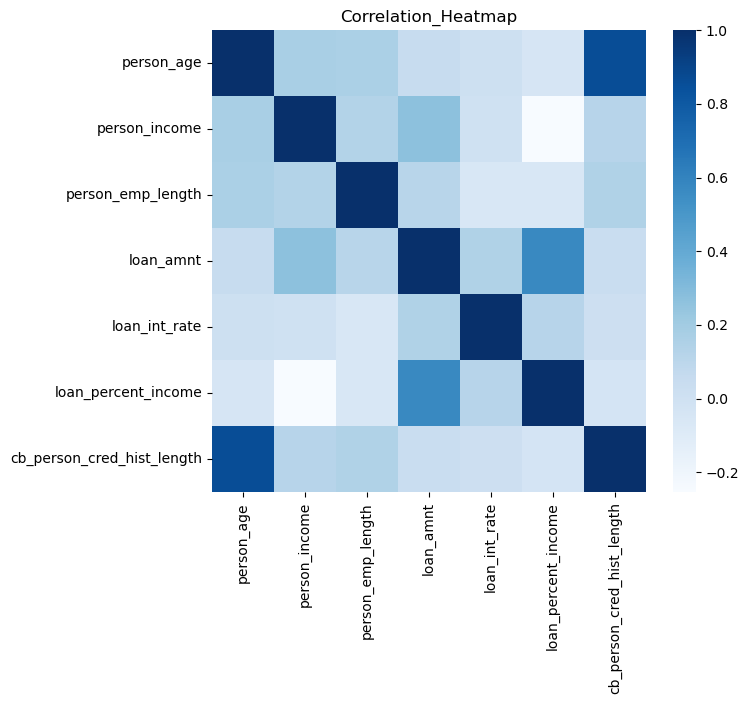

In [26]:
df.describe()
#correlation heatmap for numerical columns
plt.figure(figsize=(7,6))
sns.heatmap(df[num_col].corr(), annot=False, cmap="Blues")
plt.title("Correlation_Heatmap")
plt.show()


Target column's Distribution check

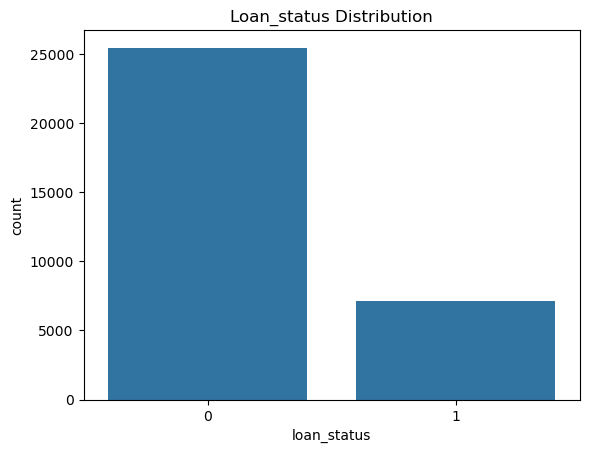

In [29]:
target = "loan_status"
sns.countplot(x=df[target])
plt.title("Loan_status Distribution")
plt.show()

Dataset split for classification

In [44]:
X = df.drop(columns=[target])
Y = df[target]
#identifying Column types
num_features=X.select_dtypes(include=["int64","float64"]).columns
cat_features=X.select_dtypes(include=["object","category"]).columns
num_features, cat_features
#Train_Test_Split
X_train,X_test,Y_train,Y_test = train_test_split(X,Y, test_size=0.2, random_state=40,stratify=Y) # "stratify=Y" Ensures that the proportion of classes in y is the same in both the training set and test set.


Model Testing

In [45]:
model = RandomForestClassifier(n_estimators=300, max_depth =None, class_weight = "balanced", random_state =40)
clf_pipeline = Pipeline(steps=[("preprocessor", preprocessor),("classifier",model)])
clf_pipeline
# n_estimators=300=Number of decision trees in the forest.
# max_depth=None=Maximum depth of each tree. "None" → trees grow until all leaves are pure (no further splitting possible) or until a leaf has fewer samples than min_samples_split.
#class_weight="balanced" -> Used in classification with imbalanced classes. Prevents the model from ignoring the minority class.


,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[(' num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [47]:
clf_pipeline.fit(X_train, Y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[(' num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


Evaluation

In [48]:
Y_pred = clf_pipeline.predict(X_test)
print("\n Clssification Report:\n")
print(classification_report(Y_test,Y_pred))


 Clssification Report:

              precision    recall  f1-score   support

           0       0.93      1.00      0.96      5095
           1       0.98      0.72      0.83      1422

    accuracy                           0.94      6517
   macro avg       0.95      0.86      0.89      6517
weighted avg       0.94      0.94      0.93      6517



Report Explaination


"""
-> Class 0 (loan_status = 0)
-> Precision 0.93: 93% of loans predicted as 0 (no default) were actually 0.
-> Recall 1.00: Model detected 100% of actual 0s. Very good!
-> F1-score 0.96: Balance of precision & recall.
-> Support 5095: There were 5095 non-default loans in the test set.
-> Interpretation: The model is excellent at identifying non-default loans.
"""



"""
-> Class 1 (loan_status = 1)
-> Precision 0.98: 98% of loans predicted as default were actually default.
-> Recall 0.72: Model detected only 72% of actual defaults.
-> F1-score 0.83: Good balance, but lower than class 0.
-> Support 1422: 1422 default loans in the test set.
-> Interpretation: The model is very precise when predicting defaults (few false positives), but it misses some actual defaults (28% of defaults were not detected).
"""

"""
Overall metrics
-> Accuracy 0.94: 94% of all predictions (both 0 and 1) were correct.
-> Macro avg: Average metrics treating both classes equally (ignores class size).
-> Precision 0.95, Recall 0.86, F1 0.89: Highlights that minority class (defaults) is not detected perfectly.
-> Weighted avg: Average metrics weighted by class support (more realistic for imbalanced datasets).
-> Precision 0.94, Recall 0.94, F1 0.93: Weighted by 5095 vs 1422 samples.
"""

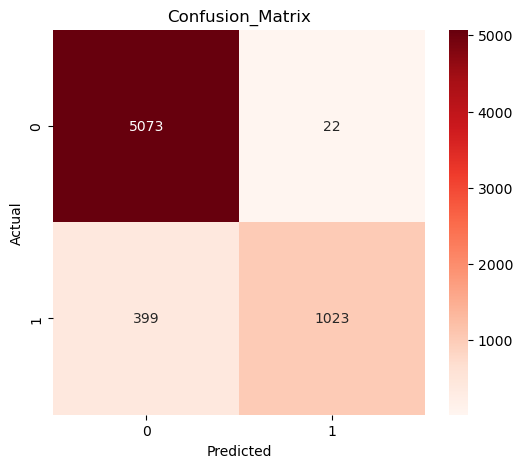

In [56]:
#confusion Matrix Visualization 
#A confusion matrix is a table used to evaluate the performance of a classification model, especially in binary or multiclass classification. It shows how many predictions were correct vs incorrect for each class.
CM = confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(CM, annot = True, fmt="d", cmap="Reds") # "annot=True" Puts the numeric values inside each square of the heatmap.
#fmt="d", Formatting for the annotation text."d" = integer format
plt.title("Confusion_Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Feature Importance Analysis

In [57]:
# Extract feature names from preprocessing
ohe_features = clf_pipeline.named_steps["preprocessor"] \
    .named_transformers_["cat"] \
    .named_steps["encoder"] \
    .get_feature_names_out(cat_features)

all_features = np.concatenate([num_features, ohe_features])

importances = clf_pipeline.named_steps["classifier"].feature_importances_
feat_imp = pd.DataFrame({"feature": all_features, "importance": importances})
feat_imp = feat_imp.sort_values(by="importance", ascending=False)

feat_imp.head(20)

,feature,importance
5,loan_percent_income,0.195930
1,person_income,0.159684
4,loan_int_rate,0.132651
3,loan_amnt,0.082072
2,person_emp_length,0.054645
20,loan_grade_D,0.050208
0,person_age,0.049298
10,person_home_ownership_RENT,0.040143
6,cb_person_cred_hist_length,0.039220
7,person_home_ownership_MORTGAGE,0.021479
